# Utilisation des machines à vecteur de suppport (SVM)
1. Ouverture / visualisation des images
2. Ouverture / visualisation des imagettes pour l'entraînement
3. Split des données
4. Entrainement du modèle
5. Application à la segmentation
6. Optimisation
7. Conclusion

## 1. Ouverture / visualisation des images


In [1]:
from socket import SO_VM_SOCKETS_BUFFER_SIZE
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.svm import SVC
from tqdm.notebook import tqdm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from random import shuffle
from skimage.io import imread, imshow

import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os 
import glob
import random

#### Ouverture des images étudiées

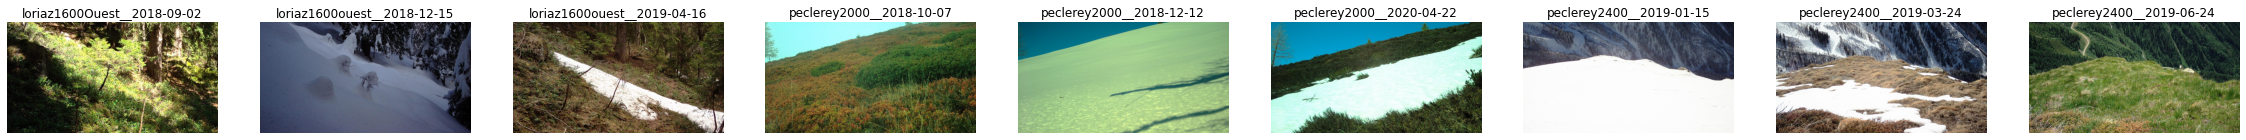

In [2]:
dir  = os.getcwd()
dir,__ = os.path.split(dir)
imgs_path = os.listdir(dir + '/data/Ref/Imgs')
imgs_path.sort()

imgs = []
for i in imgs_path:
    imgs.append(imread(f"{dir}/data/Ref/Imgs/{i}"))

fig, axs = plt.subplots(1, 9, figsize = (40, 10))
for i in range(len(imgs)):
    axs[i].imshow(imgs[i])
    axs[i].set_title(imgs_path[i][:-17])
    axs[i].set_axis_off()
plt.show()

## 2. Ouverture / visualisation des imagettes pour l'entraînement

In [3]:
def getTrainningRef(patchSize):
    """ patchSize = 5, 9 ou 25 """  
    trainImagettesNeige = [] 
    trainImagettesSansNeige = [] 
    os.chdir(dir + f'/data/Supervise/{patchSize}/')

    # sélection des imagettes positives
    imgs_path = os.listdir('Avec_neige')
    for i in imgs_path:
        trainImagettesNeige.append(cv.imread(f'Avec_neige/{i}'))
    random.Random(1337).shuffle(trainImagettesNeige)

    # sélection des imagettes négatives
    imgs_path = os.listdir('Sans_neige')
    for i in imgs_path:
        trainImagettesSansNeige.append(cv.imread(f"Sans_neige/{i}"))
    random.Random(1337).shuffle(trainImagettesNeige)

    return trainImagettesSansNeige, trainImagettesNeige
patchSize = 9
trainImagettesSansNeige, trainImagettesNeige = getTrainningRef(patchSize)

visualisation d'un échantillon des données d'entrainement 

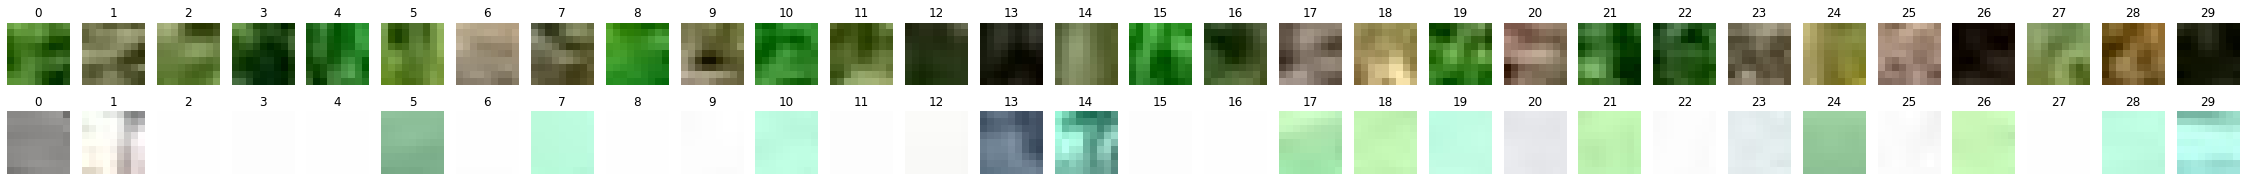

In [4]:
fig, axs = plt.subplots(2, 30, figsize = (40, 3))
for i, imS, imA in zip(range(30), trainImagettesSansNeige[::10], trainImagettesNeige[::10]):
    axs[0][i].imshow(cv.cvtColor(imS, cv.COLOR_BGR2RGB))
    axs[0][i].set_title(i)
    axs[0][i].set_axis_off()

    axs[1][i].imshow(cv.cvtColor(imA, cv.COLOR_BGR2RGB))
    axs[1][i].set_title(i)
    axs[1][i].set_axis_off()
plt.show()

## 3. Split des données

In [5]:
X, y = [], []
for img in trainImagettesSansNeige[::]:
    X.append(cv.cvtColor(img, cv.COLOR_BGR2GRAY).flatten())
    y.append(0) # label sans neige

for img in trainImagettesNeige[::]:
    X.append(cv.cvtColor(img, cv.COLOR_BGR2GRAY).flatten())
    y.append(1)# label avec neige

print("nb img for trainning =",len(y)/2)
# split : 70% training, 30% validation
X, y = np.array(X), np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

nb img for trainning = 3393.0


## 4. Entrainement du modèle

In [6]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

## 5. Application à la segmentation

In [7]:
def estDeLaNeige(img):
    """
    entrée: image à classifier
    sortie: booléen vrai = neige / faux = sansNeige
    """
    return clf.predict([cv.cvtColor(img, cv.COLOR_BGR2GRAY).flatten()]) == 1

In [8]:
res = []
for img in tqdm(imgs):
    shape = np.shape(img)
    segmented = np.ones((1008,1920))*False
    for j in range(0, len(img[0])-patchSize-1, patchSize):
        for i in range(0, len(img)-patchSize-1, patchSize):
            patch = img[i:i+patchSize,j:j+patchSize]
            try:
                if estDeLaNeige(patch):
                    segmented[i:i+patchSize,j:j+patchSize] = True
            except:
                None
    res.append(segmented)

  0%|          | 0/9 [00:00<?, ?it/s]

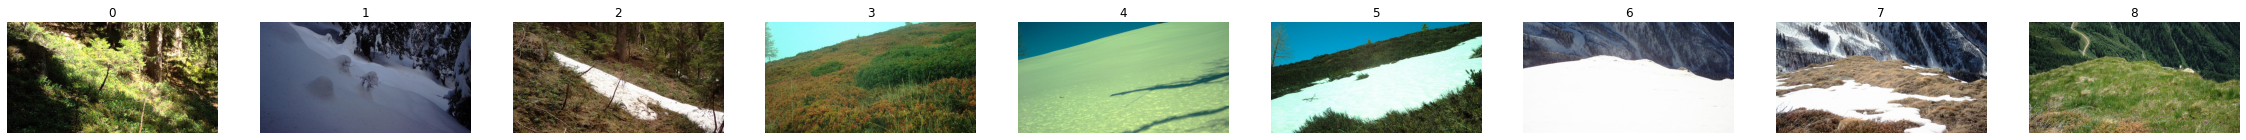

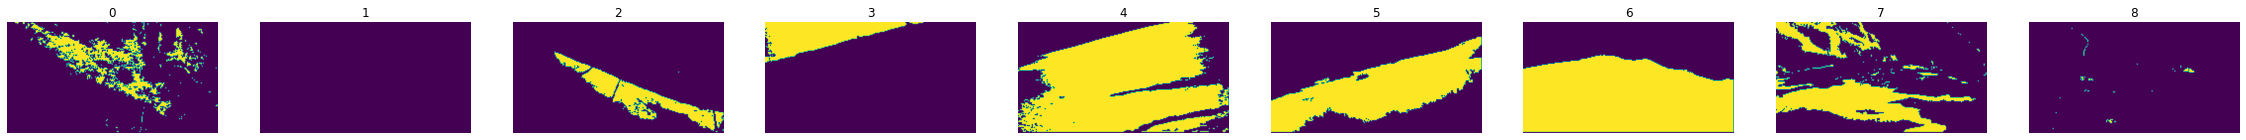

In [9]:
fig, axs = plt.subplots(2, 9, figsize = (40, 10))
for i, im, r in zip(range(9), imgs, res):
    axs[0][i].imshow(im)
    axs[0][i].set_title(i)
    axs[0][i].set_axis_off()

    axs[1][i].imshow(r)
    axs[1][i].set_title(i)
    axs[1][i].set_axis_off()
plt.show()

## 6. Optimisation

#### Déterination du nombre minimal de données d'entrînement à considérer

In [10]:
widths = [25, 9, 5]
perf=[]

for n in widths:
    trainImagettesSansNeige, trainImagettesNeige = getTrainningRef(n)
    i=0
    print("width", n)
    temp = []
    for k in tqdm(range(int(len(trainImagettesSansNeige)/10))): # ATTENTION 
        i += 10 # ATTENTION

        X, y = [], []
        for img in trainImagettesSansNeige[i:]:
            X.append(cv.cvtColor(img, cv.COLOR_BGR2GRAY).flatten())
            y.append(0) # label sans neige

        for img in trainImagettesNeige[i:]:
            X.append(cv.cvtColor(img, cv.COLOR_BGR2GRAY).flatten())
            y.append(1)# label avec neige

        if len(X)!=0:
            X, y = np.array(X), np.array(y)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
            # noyau gaussien par défaut
            clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
            clf.fit(X, y)

        y_true = y_test
        y_pred = clf.predict(X_test)

        # f1 score
        f1 = f1_score(y_true, y_pred)

        # Accuracy is purely how much percentage of cases that you have predicted correctly overall.
        accuracy = accuracy_score(y_true, y_pred)

        # Recall measures how much percentage of real positive cases are correctly identified.
        recall = recall_score(y_true, y_pred)

        # Precision measures that among the cases predicted to be positive, how much percentage of them are really positive.
        precision = precision_score(y_true, y_pred)

        temp.append(f1)
    
    perf.append(temp)

width 25


  0%|          | 0/196 [00:00<?, ?it/s]

width 9


  0%|          | 0/339 [00:00<?, ?it/s]

width 5


  0%|          | 0/332 [00:00<?, ?it/s]

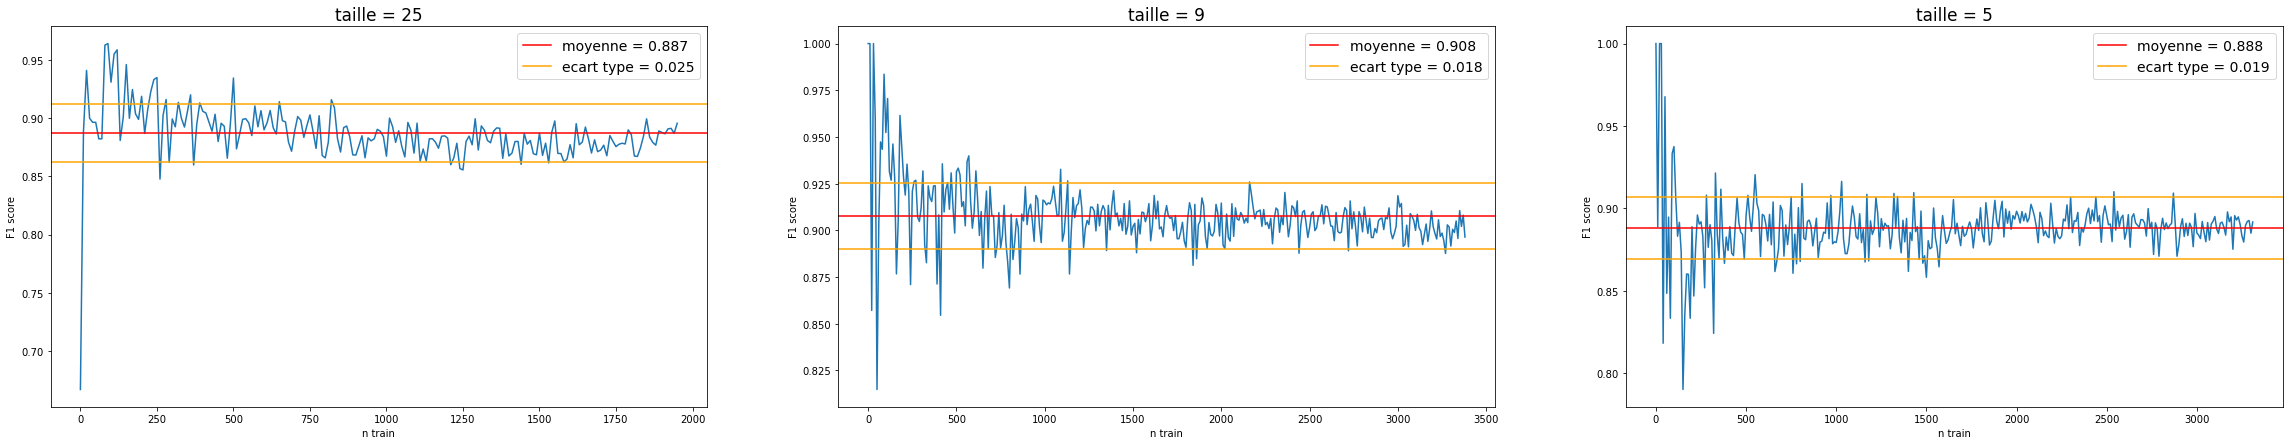

In [11]:
x = range(0, 3393, 10)
fig, axs = plt.subplots(1, 3, figsize = (40, 7))
plt.rcParams.update({'font.size': 14})
for i, width in zip(range(4), widths):

    axs[i].plot(x[:len(perf[i])], np.flip(perf[i]))
    moy = np.mean(perf[i])
    axs[i].axhline(moy, color='r', label = f"moyenne = {round(moy, 3)}")
    axs[i].axhline(moy + np.std(perf[i]), color='orange', label = f"ecart type = {round(np.std(perf[i]), 3)}")
    axs[i].axhline(moy - np.std(perf[i]), color='orange')
    axs[i].set_title(f"taille = {width}")
    axs[i].legend()
    axs[i].set_ylabel("F1 score")
    axs[i].set_xlabel("n train")
plt.show()

#### Influence du noyau utilisé
Taille de patch fixée à 9

In [12]:
patchSize = 9
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
perf=[]

for ker in tqdm(kernels):
    print("kernels", ker)

    temp = []
    for i in range(30):
        trainImagettesSansNeige, trainImagettesNeige = getTrainningRef(patchSize)
        seed = random.randint(1, 2000)
        random.Random(seed).shuffle(trainImagettesSansNeige)
        random.Random(seed).shuffle(trainImagettesNeige)

        X, y = [], []
        for img in trainImagettesSansNeige[i:]:
            X.append(cv.cvtColor(img, cv.COLOR_BGR2GRAY).flatten())
            y.append(0) # label sans neige

        for img in trainImagettesNeige[i:]:
            X.append(cv.cvtColor(img, cv.COLOR_BGR2GRAY).flatten())
            y.append(1)# label avec neige

        if len(X)!=0:
            X, y = np.array(X), np.array(y)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
            # noyau gaussien par défaut
            clf = make_pipeline(StandardScaler(), SVC(kernel = ker, gamma='auto'))
            clf.fit(X, y)

        y_true = y_test
        y_pred = clf.predict(X_test)
        # f1 score
        f1 = f1_score(y_true, y_pred)
        temp.append(f1)
    perf.append(temp)

  0%|          | 0/4 [00:00<?, ?it/s]

kernels linear
kernels rbf
kernels poly
kernels sigmoid


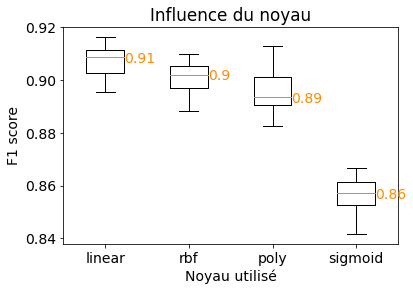

In [13]:
data = [perf[0], perf[1], perf[2], perf[3]]
m=[]
for d in data:
    m.append(round(np.median(d), 2))
fig, ax = plt.subplots()
ax.set_title('Influence du noyau')
ax.set_ylabel("F1 score")
ax.set_xlabel("Noyau utilisé")
bp = ax.boxplot(data)
for i, line in enumerate(bp['medians']):
    x, y = line.get_xydata()[1]
    text = f'{m[i]}'
    ax.annotate(text, xy=(x, y-0.002),color='darkorange')
ax.set_xticklabels(kernels)
plt.show()

## 7. Conclusion
Utiliser au moins 1500 imagettes pour l'entrinement et un noyau linéaire ou gaussien.